This project aims at Clustering and recommending crops based on weather and soil
conditions using Supervised Learning algorithms. The classification algorithms are used to perform crop recommendations based on
weather variables such as Temperature, Humidity and Rainfall, and fertilizers such as Nitrogen, Phosphorus and Potassium.

# **Importing the Libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

import ipywidgets
from ipywidgets import interact
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, r2_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.decomposition import PCA 
import xgboost as xgb

# **Loading The Dataset**

In [3]:
crop = pd.read_csv('datasets/Crop_recommendation.csv')

print("Shape of the Dataset :", crop.shape)

Shape of the Dataset : (2200, 8)


In [4]:
crop.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [5]:
crop.isna().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [6]:
crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [7]:
crop.drop_duplicates()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [8]:
crop.shape

(2200, 8)

# **Data Preprocessing**

## **Handling Inappropriate Data**

***Checking for Negative and 0 values in columns***

In [9]:
crop.columns

Index(['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label'], dtype='object')

In [10]:
#Checking the unique classes in label (output)
crop['label'].unique()

array(['rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas',
       'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate',
       'banana', 'mango', 'grapes', 'watermelon', 'muskmelon', 'apple',
       'orange', 'papaya', 'coconut', 'cotton', 'jute', 'coffee'],
      dtype=object)

In [11]:
#Checking the number of unique classes in label (output)
crop['label'].nunique()

22

# ***Statistical Summary of Dataset***

In [12]:
crop.describe(include="all")

,N,P,K,temperature,humidity,ph,rainfall,label
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rice
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655,NaN
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389,NaN
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267,NaN
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686,NaN
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624,NaN
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508,NaN


In [13]:
#Shows summary statistics of datset. Here we can know the data quality is good by checking how close in mean and median.
#In this dataset temperature and ph seems to have better distribution, other columns may have outliers.

In [14]:
# lets check the Summary for all the crops

print("Average Ratio of Nitrogen in the Soil : {0:.2f}".format(crop['N'].mean()))
print("Average Ratio of Phosphorous in the Soil : {0:.2f}".format(crop['P'].mean()))
print("Average Ratio of Potassium in the Soil : {0:.2f}".format(crop['K'].mean()))
print("Average Tempature in Celsius : {0:.2f}".format(crop['temperature'].mean()))
print("Average Relative Humidity in % : {0:.2f}".format(crop['humidity'].mean()))
print("Average PH Value of the soil : {0:.2f}".format(crop['ph'].mean()))
print("Average Rainfall in mm : {0:.2f}".format(crop['rainfall'].mean()))

Average Ratio of Nitrogen in the Soil : 50.55
Average Ratio of Phosphorous in the Soil : 53.36
Average Ratio of Potassium in the Soil : 48.15
Average Tempature in Celsius : 25.62
Average Relative Humidity in % : 71.48
Average PH Value of the soil : 6.47
Average Rainfall in mm : 103.46


In [15]:
# lets check the Summary Statistics for each of the Crops

@interact
def summary(crops = list(crop['label'].value_counts().index)):
    x = crop[crop['label'] == crops]
    print("---------------------------------------------")
    print("Statistics for Nitrogen")
    print("Minimum Nitrigen required :", x['N'].min())
    print("Average Nitrogen required :", x['N'].mean())
    print("Maximum Nitrogen required :", x['N'].max()) 
    print("---------------------------------------------")
    print("Statistics for Phosphorous")
    print("Minimum Phosphorous required :", x['P'].min())
    print("Average Phosphorous required :", x['P'].mean())
    print("Maximum Phosphorous required :", x['P'].max()) 
    print("---------------------------------------------")
    print("Statistics for Potassium")
    print("Minimum Potassium required :", x['K'].min())
    print("Average Potassium required :", x['K'].mean())
    print("Maximum Potassium required :", x['K'].max()) 
    print("---------------------------------------------")
    print("Statistics for Temperature")
    print("Minimum Temperature required : {0:.2f}".format(x['temperature'].min()))
    print("Average Temperature required : {0:.2f}".format(x['temperature'].mean()))
    print("Maximum Temperature required : {0:.2f}".format(x['temperature'].max()))
    print("---------------------------------------------")
    print("Statistics for Humidity")
    print("Minimum Humidity required : {0:.2f}".format(x['humidity'].min()))
    print("Average Humidity required : {0:.2f}".format(x['humidity'].mean()))
    print("Maximum Humidity required : {0:.2f}".format(x['humidity'].max()))
    print("---------------------------------------------")
    print("Statistics for PH")
    print("Minimum PH required : {0:.2f}".format(x['ph'].min()))
    print("Average PH required : {0:.2f}".format(x['ph'].mean()))
    print("Maximum PH required : {0:.2f}".format(x['ph'].max()))
    print("---------------------------------------------")
    print("Statistics for Rainfall")
    print("Minimum Rainfall required : {0:.2f}".format(x['rainfall'].min()))
    print("Average Rainfall required : {0:.2f}".format(x['rainfall'].mean()))
    print("Maximum Rainfall required : {0:.2f}".format(x['rainfall'].max()))

interactive(children=(Dropdown(description='crops', options=('rice', 'maize', 'jute', 'cotton', 'coconut', 'pa…

In [16]:
## Lets compare the Average Requirement for each crops with average conditions

@interact
def compare(conditions = ['N','P','K','temperature','ph','humidity','rainfall']):
    print("Average Value for", conditions,"is {0:.2f}".format(crop[conditions].mean()))
    print("----------------------------------------------")
    print("Rice : {0:.2f}".format(crop[(crop['label'] == 'rice')][conditions].mean()))
    print("Black Grams : {0:.2f}".format(crop[crop['label'] == 'blackgram'][conditions].mean()))
    print("Banana : {0:.2f}".format(crop[(crop['label'] == 'banana')][conditions].mean()))
    print("Jute : {0:.2f}".format(crop[crop['label'] == 'jute'][conditions].mean()))
    print("Coconut : {0:.2f}".format(crop[(crop['label'] == 'coconut')][conditions].mean()))
    print("Apple : {0:.2f}".format(crop[crop['label'] == 'apple'][conditions].mean()))
    print("Papaya : {0:.2f}".format(crop[(crop['label'] == 'papaya')][conditions].mean()))
    print("Muskmelon : {0:.2f}".format(crop[crop['label'] == 'muskmelon'][conditions].mean()))
    print("Grapes : {0:.2f}".format(crop[(crop['label'] == 'grapes')][conditions].mean()))
    print("Watermelon : {0:.2f}".format(crop[crop['label'] == 'watermelon'][conditions].mean()))
    print("Kidney Beans: {0:.2f}".format(crop[(crop['label'] == 'kidneybeans')][conditions].mean()))
    print("Mung Beans : {0:.2f}".format(crop[crop['label'] == 'mungbean'][conditions].mean()))
    print("Oranges : {0:.2f}".format(crop[(crop['label'] == 'orange')][conditions].mean()))
    print("Chick Peas : {0:.2f}".format(crop[crop['label'] == 'chickpea'][conditions].mean()))
    print("Lentils : {0:.2f}".format(crop[(crop['label'] == 'lentil')][conditions].mean()))
    print("Cotton : {0:.2f}".format(crop[crop['label'] == 'cotton'][conditions].mean()))
    print("Maize : {0:.2f}".format(crop[(crop['label'] == 'maize')][conditions].mean()))
    print("Moth Beans : {0:.2f}".format(crop[crop['label'] == 'mothbeans'][conditions].mean()))
    print("Pigeon Peas : {0:.2f}".format(crop[(crop['label'] == 'pigeonpeas')][conditions].mean()))
    print("Mango : {0:.2f}".format(crop[crop['label'] == 'mango'][conditions].mean()))
    print("Pomegranate : {0:.2f}".format(crop[(crop['label'] == 'pomegranate')][conditions].mean()))
    print("Coffee : {0:.2f}".format(crop[crop['label'] == 'coffee'][conditions].mean()))

interactive(children=(Dropdown(description='conditions', options=('N', 'P', 'K', 'temperature', 'ph', 'humidit…

In [17]:
@interact
def compare(conditions = ['N','P','K','temperature','ph','humidity','rainfall']):
    print("Crops which require greater than average", conditions,'\n')
    print(crop[crop[conditions] > crop[conditions].mean()]['label'].unique())
    print("----------------------------------------------")
    print("Crops which require less than average", conditions,'\n')
    print(crop[crop[conditions] <= crop[conditions].mean()]['label'].unique())

interactive(children=(Dropdown(description='conditions', options=('N', 'P', 'K', 'temperature', 'ph', 'humidit…

# **Visualization**

In [18]:
# #Checking the relationship between all the variables
# sns.pairplot(crop,hue = 'label')

In [19]:
#In above plot, we can see that histograms in diagonal are mostly overlapped and through
#other scatter plots we can see that the classes are not linearly separable so we try visualizing through other graphs.

In [20]:
#Throgh these boxplots, we are not able to see any outliers so we can try for individual columns.

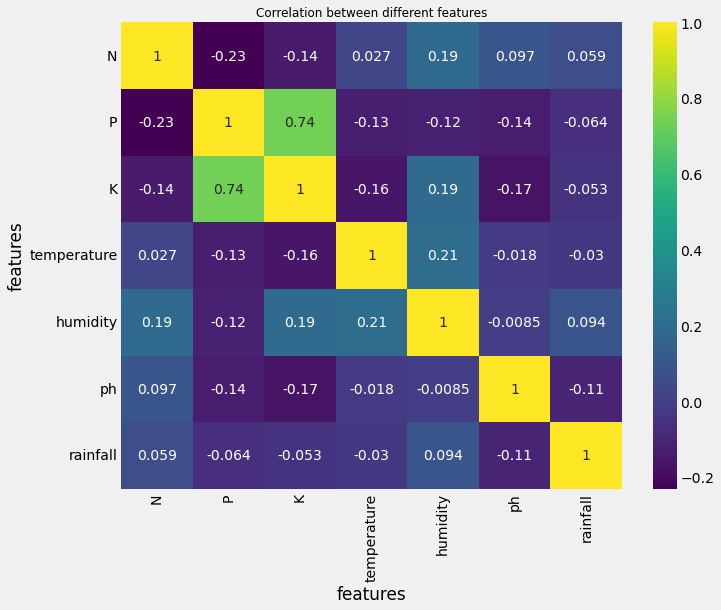

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(crop.corr(), annot=True,cmap='viridis')
ax.set(xlabel='features')
ax.set(ylabel='features')

plt.title('Correlation between different features', fontsize = 12, c='black')
plt.show()

In [22]:
#Correlation between Potassium and Phosphorus is high.

In [23]:
crop_summary = pd.pivot_table(crop,index=['label'],aggfunc='mean')
crop_summary.head()

,K,N,P,humidity,ph,rainfall,temperature
label,,,,,,,
apple,199.89,20.80,134.22,92.333383,5.929663,112.654779,22.630942
banana,50.05,100.23,82.01,80.358123,5.983893,104.626980,27.376798
blackgram,19.24,40.02,67.47,65.118426,7.133952,67.884151,29.973340
chickpea,79.92,40.09,67.79,16.860439,7.336957,80.058977,18.872847
coconut,30.59,21.98,16.93,94.844272,5.976562,175.686646,27.409892


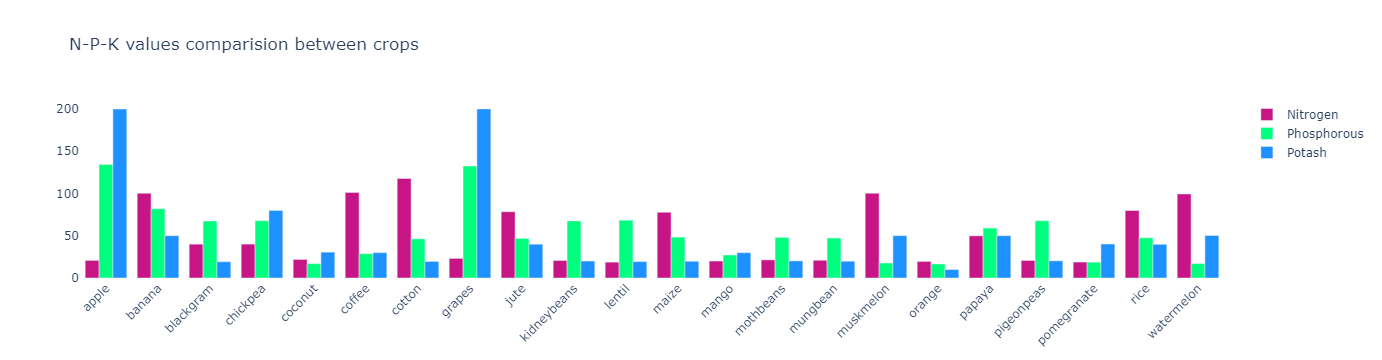

In [24]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=crop_summary.index,
    y=crop_summary['N'],
    name='Nitrogen',
    marker_color='mediumvioletred'
))
fig.add_trace(go.Bar(
    x=crop_summary.index,
    y=crop_summary['P'],
    name='Phosphorous',
    marker_color='springgreen'
))
fig.add_trace(go.Bar(
    x=crop_summary.index,
    y=crop_summary['K'],
    name='Potash',
    marker_color='dodgerblue'
))

fig.update_layout(title="N-P-K values comparision between crops",
                  plot_bgcolor='white',
                  barmode='group',
                  xaxis_tickangle=-45)

fig.show()

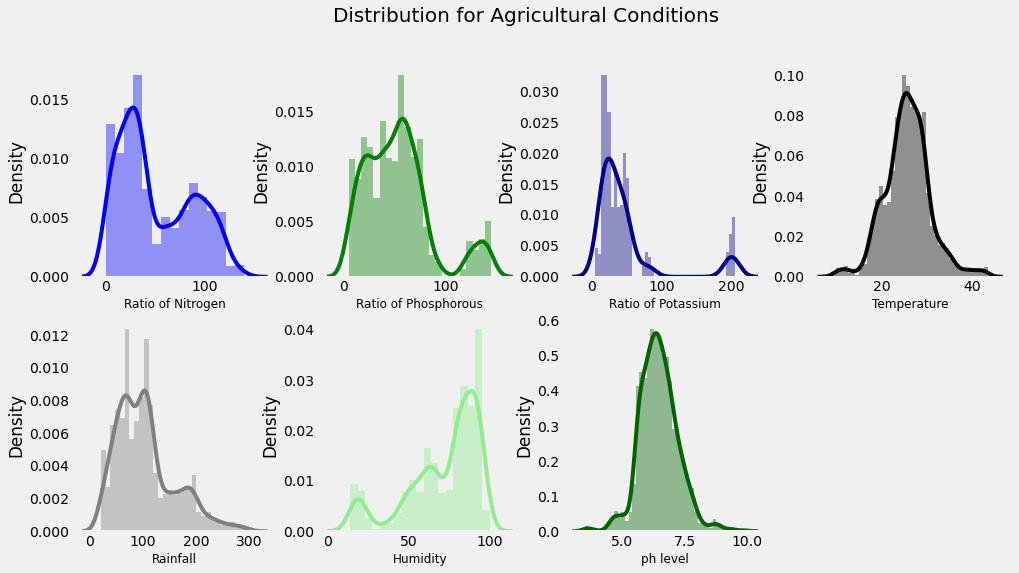

In [25]:
#Distribution for Agricultural Conditions
plt.figure(figsize=(15,8))
plt.subplot(2,4,1)
sns.distplot(crop['N'],color = 'blue')
plt.xlabel('Ratio of Nitrogen',fontsize = 12)
plt.grid()

plt.subplot(2,4,2)
sns.distplot(crop['P'],color = 'green')
plt.xlabel('Ratio of Phosphorous',fontsize = 12)
plt.grid()

plt.subplot(2,4,3)
sns.distplot(crop['K'],color = 'darkblue')
plt.xlabel('Ratio of Potassium',fontsize = 12)
plt.grid()

plt.subplot(2,4,4)
sns.distplot(crop['temperature'],color = 'black')
plt.xlabel('Temperature',fontsize = 12)
plt.grid()

plt.subplot(2,4,5)
sns.distplot(crop['rainfall'],color = 'grey')
plt.xlabel('Rainfall',fontsize = 12)
plt.grid()

plt.subplot(2,4,6)
sns.distplot(crop['humidity'],color = 'lightgreen')
plt.xlabel('Humidity',fontsize = 12)
plt.grid()

plt.subplot(2,4,7)
sns.distplot(crop['ph'],color = 'darkgreen')
plt.xlabel('ph level',fontsize = 12)
plt.grid()

plt.suptitle('Distribution for Agricultural Conditions', fontsize = 20)
plt.show()

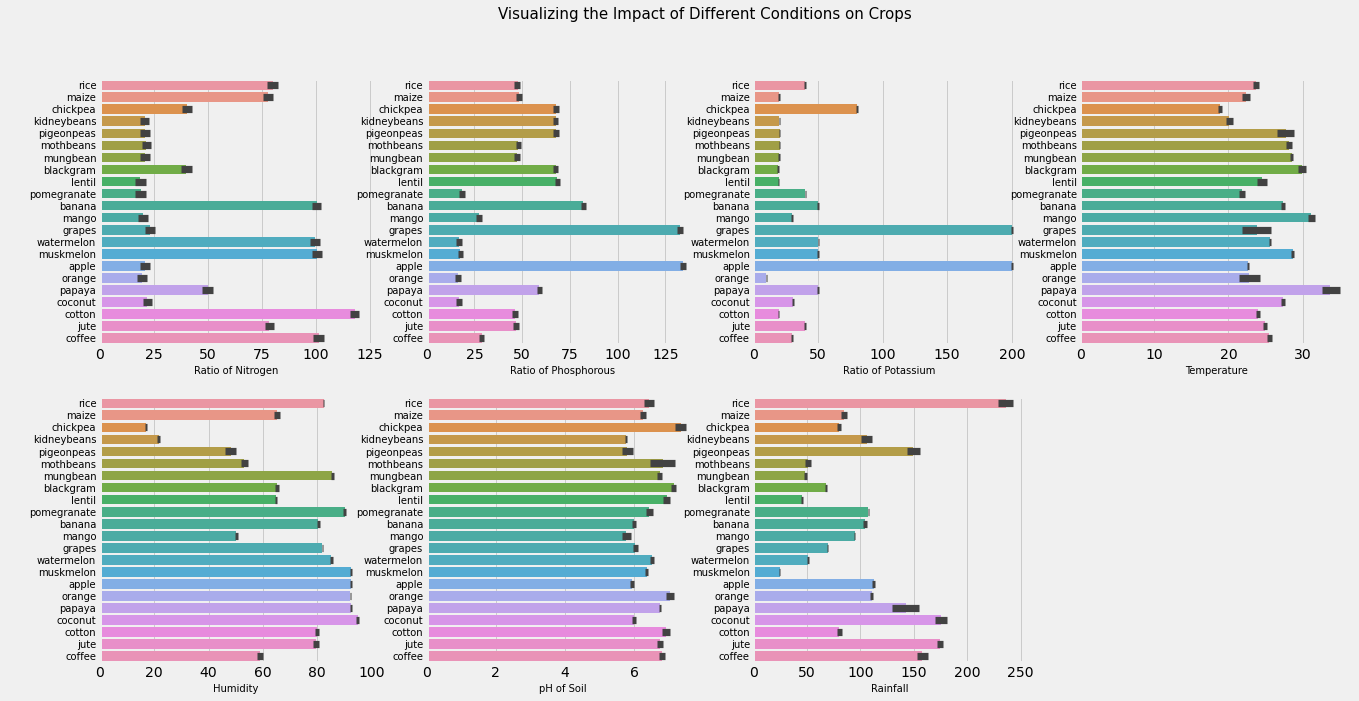

In [26]:
### Data Visualizations

plt.rcParams['figure.figsize'] = (20,10)

plt.subplot(2, 4, 1)
sns.barplot(crop['N'], crop['label'])
plt.ylabel(' ')
plt.xlabel('Ratio of Nitrogen', fontsize = 10)
plt.yticks(fontsize = 10)

plt.subplot(2, 4, 2)
sns.barplot(crop['P'], crop['label'])
plt.ylabel(' ')
plt.xlabel('Ratio of Phosphorous', fontsize = 10)
plt.yticks(fontsize = 10)

plt.subplot(2, 4, 3)
sns.barplot(crop['K'], crop['label'])
plt.ylabel(' ')
plt.xlabel('Ratio of Potassium', fontsize = 10)
plt.yticks(fontsize = 10)

plt.subplot(2, 4, 4)
sns.barplot(crop['temperature'], crop['label'])
plt.ylabel(' ')
plt.xlabel('Temperature', fontsize = 10)
plt.yticks(fontsize = 10)

plt.subplot(2, 4, 5)
sns.barplot(crop['humidity'], crop['label'])
plt.ylabel(' ')
plt.xlabel('Humidity', fontsize = 10)
plt.yticks(fontsize = 10)

plt.subplot(2, 4, 6)
sns.barplot(crop['ph'], crop['label'])
plt.ylabel(' ')
plt.xlabel('pH of Soil', fontsize = 10)
plt.yticks(fontsize = 10)

plt.subplot(2, 4, 7)
sns.barplot(crop['rainfall'], crop['label'])
plt.ylabel(' ')
plt.xlabel('Rainfall', fontsize = 10)
plt.yticks(fontsize = 10)

plt.suptitle('Visualizing the Impact of Different Conditions on Crops', fontsize = 15)
plt.show()

## **OUTLIER ANALYSIS AND REMOVAL**

<AxesSubplot:xlabel='label', ylabel='ph'>

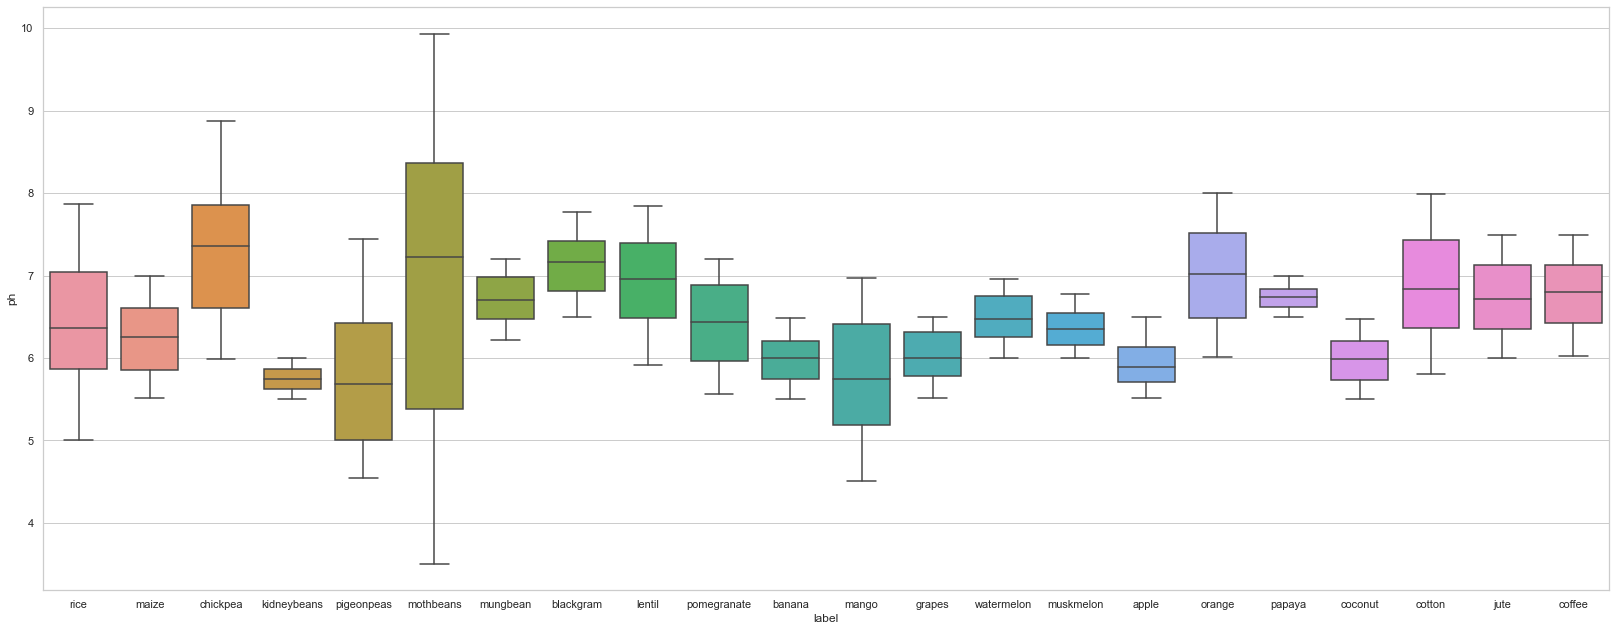

In [27]:
#Checking the outliers considering all classes of the output for ph column
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(25,10))
sns.boxplot(x='label',y='ph',data=crop)

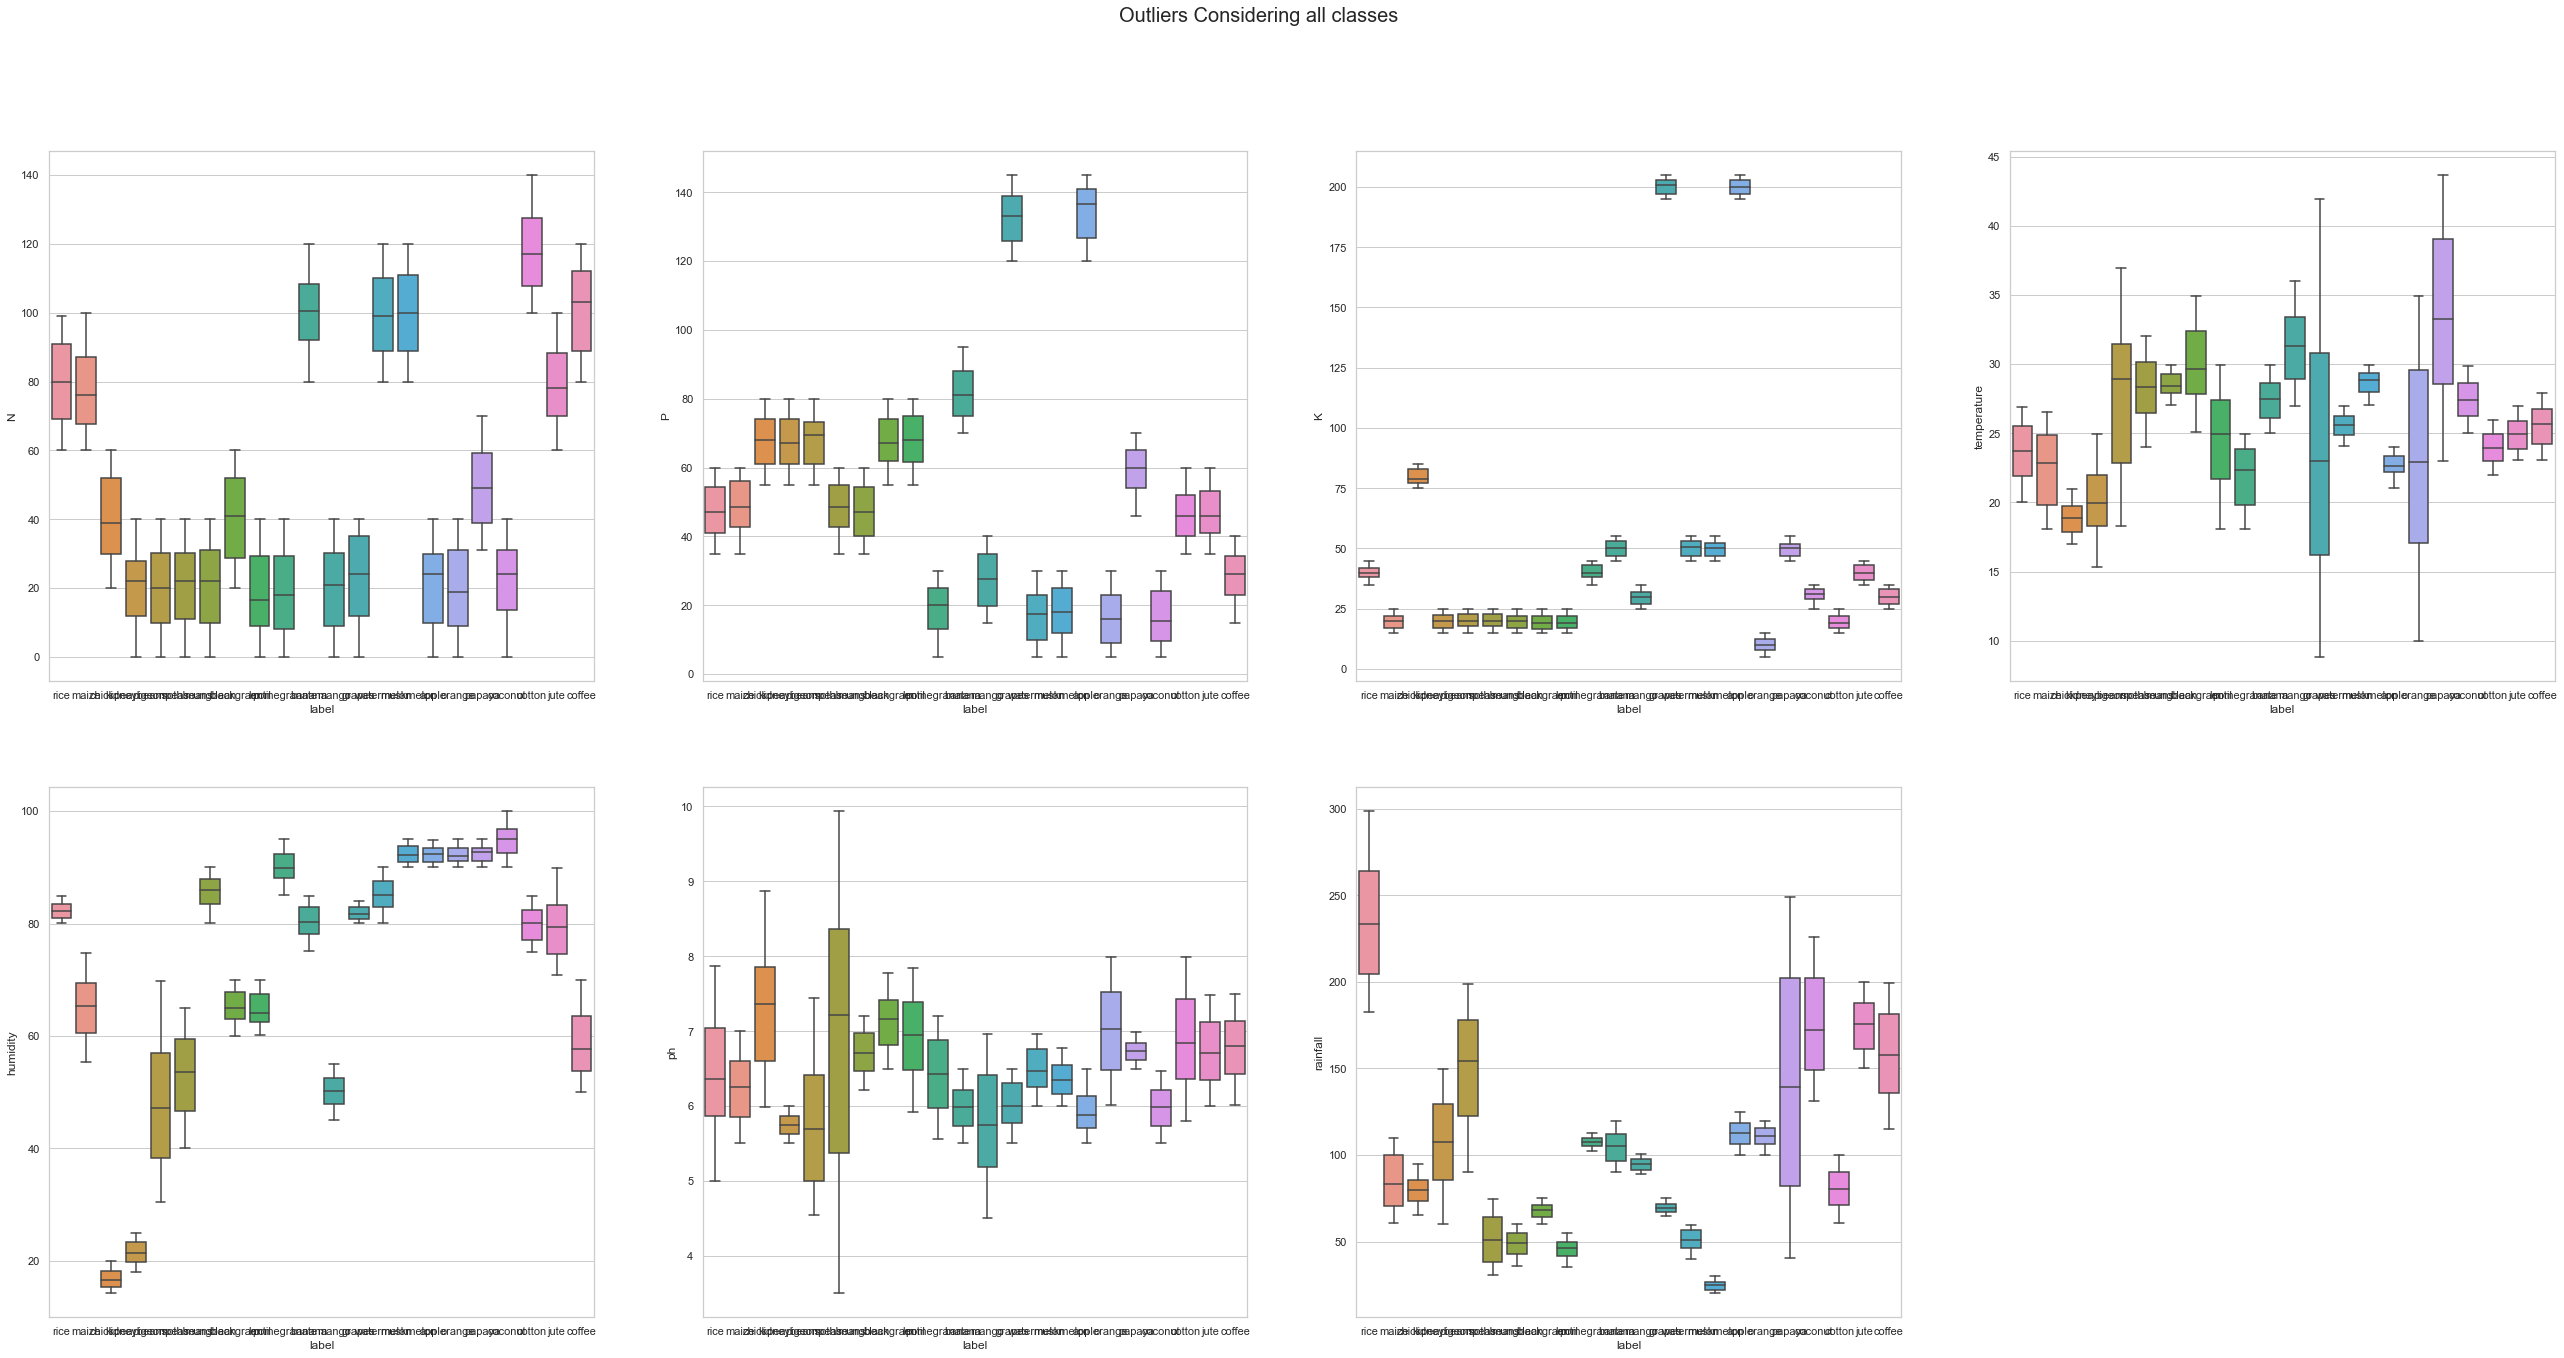

In [28]:
def graph(y):
    sns.boxplot(x="label", y=y, data=crop)
  
plt.figure(figsize=(40,20))
      
# Adding the subplot at the specified
# grid position
plt.subplot(2,4,1)
graph('N')
  
plt.subplot(2,4,2)
graph('P')
  
plt.subplot(2,4,3)
graph('K')
  
plt.subplot(2,4,4)
graph('temperature')

plt.subplot(2,4,5)
graph('humidity')

plt.subplot(2,4,6)
graph('ph')

plt.subplot(2,4,7)
graph('rainfall')

plt.suptitle('Outliers Considering all classes', fontsize = 20)
plt.show()

In [29]:
#There are no visible outliers in the above plots so considering the whole dataset

# **Clustering Smilar Crops**

***K Means Clustering***

In [30]:
### Lets try to Cluster these Crops

# lets import the warnings library so that we can avoid warnings
import warnings
warnings.filterwarnings('ignore')

x = crop.loc[:, ['N','P','K','temperature','ph','humidity','rainfall']].values

# let's check the shape of x
print(x.shape)

# lets convert this data into a dataframe
x_data  = pd.DataFrame(x)
x_data.head()

(2200, 7)


,0,1,2,3,4,5,6
0,90.0,42.0,43.0,20.879744,6.502985,82.002744,202.935536
1,85.0,58.0,41.0,21.770462,7.038096,80.319644,226.655537
2,60.0,55.0,44.0,23.004459,7.840207,82.320763,263.964248
3,74.0,35.0,40.0,26.491096,6.980401,80.158363,242.864034
4,78.0,42.0,42.0,20.130175,7.628473,81.604873,262.717340


In [ ]:
# lets determine the Optimum Number of Clusters within the Dataset
from sklearn.cluster import KMeans
plt.rcParams['figure.figsize'] = (10, 4)

wcss = []
K = range(2,10)
for i in K:
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)

# lets plot the results
plt.plot(range(2, 10), wcss)
plt.title('The Elbow Method (Optimal Clusters Kmeans)', fontsize = 15)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

In [ ]:
# implementing the K Means algorithm to perform Clustering analysis
km = KMeans(n_clusters = 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_means = km.fit_predict(x)
crop1=crop.copy()

a = crop1['label']
y_means = pd.DataFrame(y_means)
z = pd.concat([y_means, crop1], axis = 1)
z = z.rename(columns = {0: 'cluster'})
print(z)

      cluster    N   P   K  temperature   humidity        ph    rainfall  \
0           3   90  42  43    20.879744  82.002744  6.502985  202.935536   
1           3   85  58  41    21.770462  80.319644  7.038096  226.655537   
2           3   60  55  44    23.004459  82.320763  7.840207  263.964248   
3           3   74  35  40    26.491096  80.158363  6.980401  242.864034   
4           3   78  42  42    20.130175  81.604873  7.628473  262.717340   
...       ...  ...  ..  ..          ...        ...       ...         ...   
2195        3  107  34  32    26.774637  66.413269  6.780064  177.774507   
2196        1   99  15  27    27.417112  56.636362  6.086922  127.924610   
2197        3  118  33  30    24.131797  67.225123  6.362608  173.322839   
2198        1  117  32  34    26.272418  52.127394  6.758793  127.175293   
2199        3  104  18  30    23.603016  60.396475  6.779833  140.937041   

       label  
0       rice  
1       rice  
2       rice  
3       rice  
4       rice

In [ ]:
# check the Clusters of each Crops
print("K Means Clustering Analysis \n")
print("Crops in Zero Cluster:", z[z['cluster'] == 0]['label'].unique())
print("---------------------------------------------------------------")
print("Crops in First Cluster:", z[z['cluster'] == 1]['label'].unique())
print("---------------------------------------------------------------")
print("Crops in Second Cluster:", z[z['cluster'] == 2]['label'].unique())
print("---------------------------------------------------------------")
print("Crops in Third Cluster:", z[z['cluster'] == 3]['label'].unique())

K Means Clustering Analysis 

Crops in Zero Cluster: ['maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans' 'mungbean'
 'blackgram' 'lentil' 'pomegranate' 'mango' 'orange' 'papaya' 'coconut']
---------------------------------------------------------------
Crops in First Cluster: ['maize' 'banana' 'watermelon' 'muskmelon' 'papaya' 'cotton' 'coffee']
---------------------------------------------------------------
Crops in Second Cluster: ['grapes' 'apple']
---------------------------------------------------------------
Crops in Third Cluster: ['rice' 'pigeonpeas' 'papaya' 'coconut' 'jute' 'coffee']


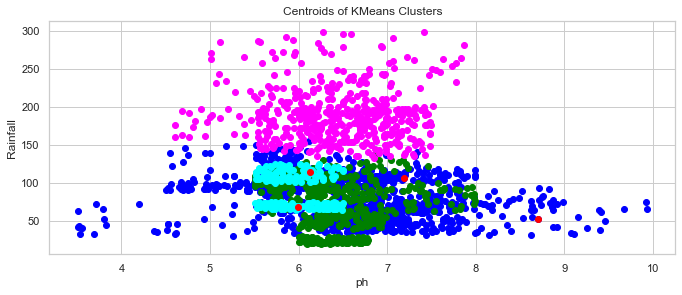

In [ ]:
K=4
Centroids = (z.sample(n=K))
color=['blue','green','cyan','magenta']
for k in range(K):
    data=z[z["cluster"]==k]
    plt.scatter(data["ph"],data["rainfall"],c=color[k])
    
plt.scatter(Centroids["ph"],Centroids["rainfall"],c='red')
plt.title("Centroids of KMeans Clusters")
plt.xlabel('ph')
plt.ylabel('Rainfall')
plt.show()

In [ ]:
# Display the predictions
for i, pred in enumerate(y_means):
    print("Sample Crop", i, "predicted to be in Cluster", pred)

Sample Crop 0 predicted to be in Cluster 0


***Hard Clustering***

In [ ]:
print("Results for Hard Clustering\n")
counts = z[z['cluster'] == 0]['label'].value_counts()
d = z.loc[z['label'].isin(counts.index[counts >= 50])]
d = d['label'].value_counts()
print("Crops in Cluster 0:", list(d.index))
print("--------------------------------------------------")
counts = z[z['cluster'] == 1]['label'].value_counts()
d = z.loc[z['label'].isin(counts.index[counts >= 50])]
d = d['label'].value_counts()
print("Crops in Cluster 1:", list(d.index))
print("--------------------------------------------------")
counts = z[z['cluster'] == 2]['label'].value_counts()
d = z.loc[z['label'].isin(counts.index[counts >= 50])]
d = d['label'].value_counts()
print("Crops in Cluster 2:", list(d.index))
print("--------------------------------------------------")
counts = z[z['cluster'] == 3]['label'].value_counts()
d = z.loc[z['label'].isin(counts.index[counts >= 50])]
d = d['label'].value_counts()
print("Crops in Cluster 3:", list(d.index))

Results for Hard Clustering

Crops in Cluster 0: ['chickpea', 'kidneybeans', 'mothbeans', 'mungbean', 'blackgram', 'lentil', 'pomegranate', 'mango', 'orange']
--------------------------------------------------
Crops in Cluster 1: ['maize', 'banana', 'watermelon', 'muskmelon', 'cotton']
--------------------------------------------------
Crops in Cluster 2: ['grapes', 'apple']
--------------------------------------------------
Crops in Cluster 3: ['rice', 'pigeonpeas', 'papaya', 'coconut', 'jute', 'coffee']


***Hierarchial Clustering***

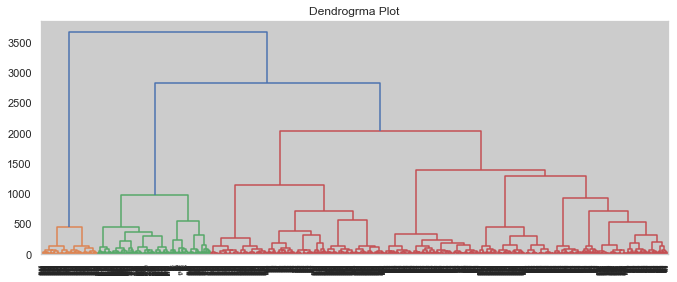

In [ ]:
import scipy.cluster.hierarchy as shc  
dendro = shc.dendrogram(shc.linkage(x, method="ward"))  
plt.title("Dendrogrma Plot")  
plt.show()

In [ ]:
#training the hierarchical model on dataset  
from sklearn.cluster import AgglomerativeClustering  
hc= AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
y_her= hc.fit_predict(x)  

# lets find out the Results
b = crop['label']
y_herr = pd.DataFrame(y_her)
w = pd.concat([y_herr, b], axis = 1)
w= w.rename(columns = {0: 'cluster'})

# lets check the Clusters of each Crops
print("Hierachical Clustering Analysis \n")
print("Crops in Zero Cluster:", w[w['cluster'] == 0]['label'].unique())
print("---------------------------------------------------------------")
print("Crops in First Cluster:", w[w['cluster'] == 1]['label'].unique())
print("---------------------------------------------------------------")
print("Crops in Second Cluster:", w[w['cluster'] == 2]['label'].unique())
print("---------------------------------------------------------------")
print("Crops in Third Cluster:", w[w['cluster'] == 3]['label'].unique())

crop.head()

Hierachical Clustering Analysis 

Crops in Zero Cluster: ['chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans' 'mungbean' 'blackgram'
 'lentil' 'pomegranate' 'mango' 'orange' 'coconut']
---------------------------------------------------------------
Crops in First Cluster: ['maize' 'blackgram' 'banana' 'watermelon' 'muskmelon' 'papaya' 'cotton']
---------------------------------------------------------------
Crops in Second Cluster: ['rice' 'papaya' 'coconut' 'jute' 'coffee']
---------------------------------------------------------------
Crops in Third Cluster: ['grapes' 'apple']


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


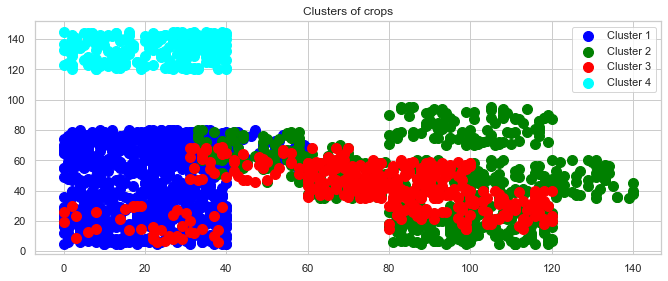

In [ ]:
#visulaizing the clusters  
plt.scatter(x[y_her == 0, 0], x[y_her == 0, 1], s = 100, c = 'blue', label = 'Cluster 1')  
plt.scatter(x[y_her == 1, 0], x[y_her == 1, 1], s = 100, c = 'green', label = 'Cluster 2')  
plt.scatter(x[y_her== 2, 0], x[y_her == 2, 1], s = 100, c = 'red', label = 'Cluster 3')  
plt.scatter(x[y_her == 3, 0], x[y_her == 3, 1], s = 100, c = 'cyan', label = 'Cluster 4')  
plt.title('Clusters of crops')  
plt.legend()  
plt.show()

***Dbscan Clustering***

In [ ]:
from numpy import unique
from numpy import where
crop.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
data_X = crop.loc[:, ['temperature',
                 'rainfall']].values
data_X.shape

(2200, 2)

In [ ]:
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(x) # fitting the data to the object
distances,indices=nbrs.kneighbors(x) 

Estimated number of clusters: 9
Estimated number of noise points: 787
Cluster 0 : 100
Cluster 1 : 415
Cluster 2 : 205
Cluster 3 : 100
Cluster 4 : 100
Cluster 5 : 98
Cluster 6 : 200
Cluster 7 : 100
Cluster 8 : 95


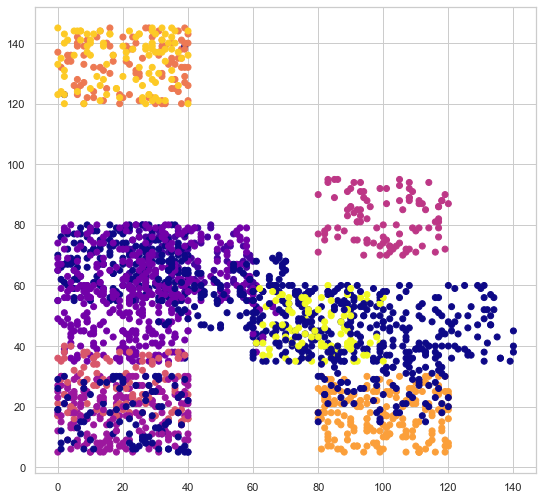

In [ ]:
dbscan = DBSCAN(eps = 25, min_samples = 90)
dbs = dbscan.fit_predict(x)

labels = dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
for i in range(n_clusters_):
    print('Cluster', i, ':', len(labels[labels==i]))

plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0], x[:,1], c = labels, cmap= "plasma") # plotting the clusters
plt.show()

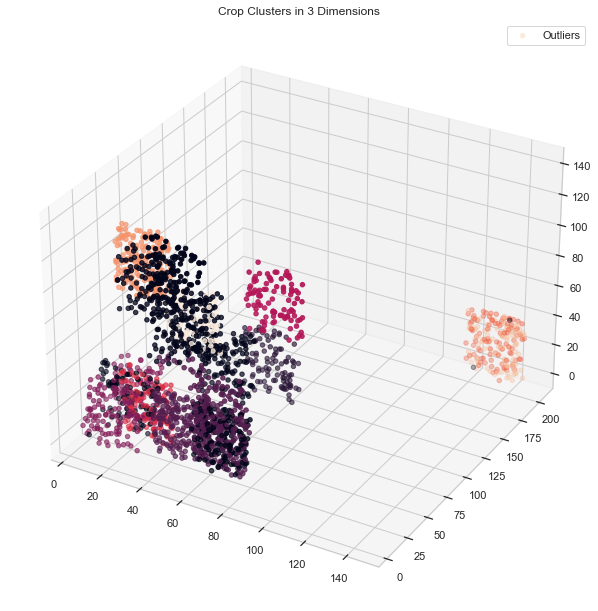

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x.T[1],x.T[2],x.T[0], 
           c=labels)
ax.set_title("Crop Clusters in 3 Dimensions")
ax.legend(['Outliers'])
plt.show()

# **Prediction**

In [ ]:
features = crop[['N', 'P','K','temperature', 'humidity', 'ph', 'rainfall']]
target = crop['label']

# **Feature Scaling**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(features,target,test_size = 0.2,random_state =2,stratify = labels)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# we must apply the scaling to the test set as well that we are computing for the training set
X_test_scaled = scaler.transform(X_test)

# **Classifier Model Selection**

***Decision Tree Classifier***

In [ ]:
tree = DecisionTreeClassifier(max_depth=20,random_state=0).fit(X_train_scaled, y_train)
tree_pred= tree.score(X_test_scaled, y_test)

tree_train_accuracy =tree.score(X_train_scaled,y_train)
tree_accuracy = tree.score(X_test_scaled,y_test)
pred_prob_tree = tree.predict_proba(X_test_scaled)

print("Training score: {:.3f}".format(tree.score(X_train_scaled, y_train)))
print("Test score: {:.3f}".format(tree.score(X_test_scaled, y_test)))

Training score: 1.000
Test score: 0.982


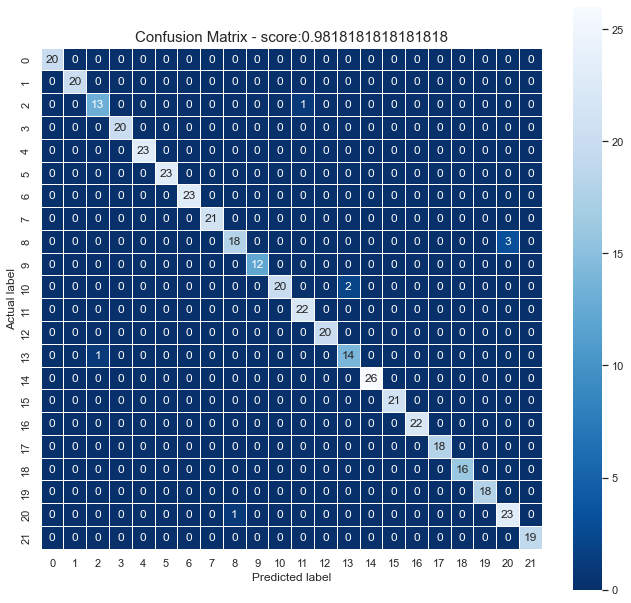

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.93      0.93      0.93        14
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        23
      coffee       1.00      1.00      1.00        23
      cotton       1.00      1.00      1.00        23
      grapes       1.00      1.00      1.00        21
        jute       0.95      0.86      0.90        21
 kidneybeans       1.00      1.00      1.00        12
      lentil       1.00      0.91      0.95        22
       maize       0.96      1.00      0.98        22
       mango       1.00      1.00      1.00        20
   mothbeans       0.88      0.93      0.90        15
    mungbean       1.00      1.00      1.00        26
   muskmelon       1.00      1.00      1.00        21
      orange       1.00      1.00      1.00        22
      papaya       1.00    

In [ ]:
tree_model=DecisionTreeClassifier(random_state=0)
tree_model.fit(X_train_scaled,y_train)
y_pred=tree_model.predict(X_test_scaled)
from sklearn import metrics

tree_cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(tree_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Confusion Matrix - score:'+str(metrics.accuracy_score(y_test,y_pred))
plt.title(all_sample_title, size = 15);
plt.show()
print(metrics.classification_report(y_test,y_pred))

***Random Forest Classifier***

In [ ]:
#max features and n_estimator are important to fine tune otherwise trees will be densely graphed which will be a classic case of overfitting.
#max_features=4 and n_estimators=10 gives pretty much satisfying results by making sure model is able to generalize well.

rf = RandomForestClassifier(n_estimators=30, max_features=6, random_state=0).fit(X_train_scaled, y_train)
rf_pred= rf.score(X_test_scaled, y_test)


rf_train_accuracy =rf.score(X_train_scaled,y_train)
rf_accuracy = rf.score(X_test_scaled,y_test)
pred_prob_rf = rf.predict_proba(X_test_scaled)


print("Training score: {:.3f}".format(rf.score(X_train_scaled, y_train)))
print("Test score: {:.3f}".format(rf.score(X_test_scaled, y_test)))

Training score: 1.000
Test score: 0.986


***Confsuion Metrics Based on Random Forest Classifier***

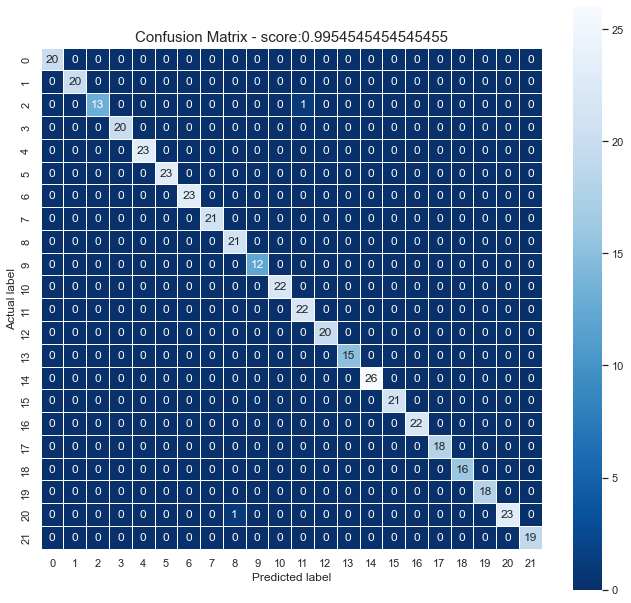

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.93      0.96        14
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        23
      coffee       1.00      1.00      1.00        23
      cotton       1.00      1.00      1.00        23
      grapes       1.00      1.00      1.00        21
        jute       0.95      1.00      0.98        21
 kidneybeans       1.00      1.00      1.00        12
      lentil       1.00      1.00      1.00        22
       maize       0.96      1.00      0.98        22
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        15
    mungbean       1.00      1.00      1.00        26
   muskmelon       1.00      1.00      1.00        21
      orange       1.00      1.00      1.00        22
      papaya       1.00    

In [ ]:
rf_model=RandomForestClassifier(random_state=0)
rf_model.fit(X_train_scaled,y_train)
y_pred=rf_model.predict(X_test_scaled)
from sklearn import metrics

rf_cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(rf_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Confusion Matrix - score:'+str(metrics.accuracy_score(y_test,y_pred))
plt.title(all_sample_title, size = 15);
plt.show()
print(metrics.classification_report(y_test,y_pred))

***Support Vector Classifier***

In [ ]:
svm = SVC(C=100, gamma=0.001).fit(X_train_scaled, y_train)
svm_pred= svm.score(X_test_scaled, y_test)

svm_train_accuracy =svm.score(X_train_scaled,y_train)
svm_accuracy = svm.score(X_test_scaled,y_test)


print("Training score: {:.3f}".format(svm.score(X_train_scaled, y_train)))
print("Test score: {:.3f}".format(svm.score(X_test_scaled, y_test)))

Training score: 0.799
Test score: 0.775


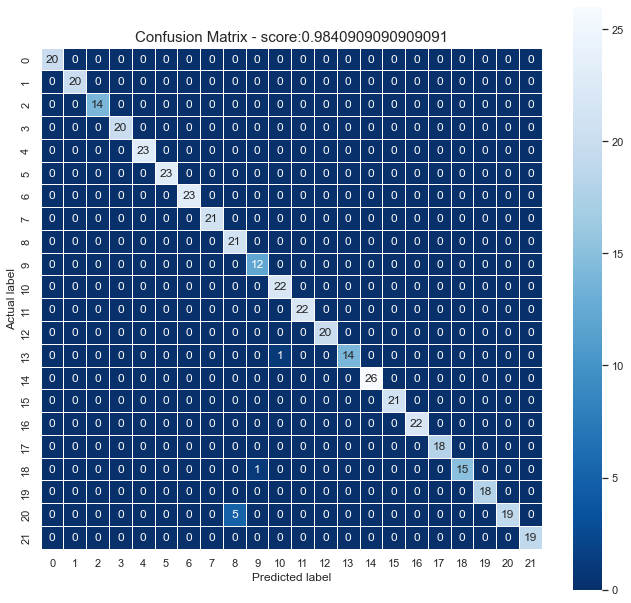

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      1.00      1.00        14
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        23
      coffee       1.00      1.00      1.00        23
      cotton       1.00      1.00      1.00        23
      grapes       1.00      1.00      1.00        21
        jute       0.81      1.00      0.89        21
 kidneybeans       0.92      1.00      0.96        12
      lentil       0.96      1.00      0.98        22
       maize       1.00      1.00      1.00        22
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      0.93      0.97        15
    mungbean       1.00      1.00      1.00        26
   muskmelon       1.00      1.00      1.00        21
      orange       1.00      1.00      1.00        22
      papaya       1.00    

In [ ]:
svc_model=SVC(random_state=0)
svc_model.fit(X_train_scaled,y_train)
y_pred=svc_model.predict(X_test_scaled)
from sklearn import metrics

svc_cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(svc_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Confusion Matrix - score:'+str(metrics.accuracy_score(y_test,y_pred))
plt.title(all_sample_title, size = 15);
plt.show()
print(metrics.classification_report(y_test,y_pred))

***KNeighbors Classifier***

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn_pred=knn.score(X_test_scaled, y_test)

knn_train_accuracy =knn.score(X_train_scaled,y_train)
knn_accuracy = knn.score(X_test_scaled,y_test)
pred_prob_knn = knn.predict_proba(X_test_scaled)

print("Training score: {:.3f}".format(knn.score(X_train_scaled, y_train)))
print("Test score: {:.3f}".format(knn.score(X_test_scaled, y_test)))

Training score: 0.991
Test score: 0.977


***Tuning the HyperParameter (k values) for KNeighbors***

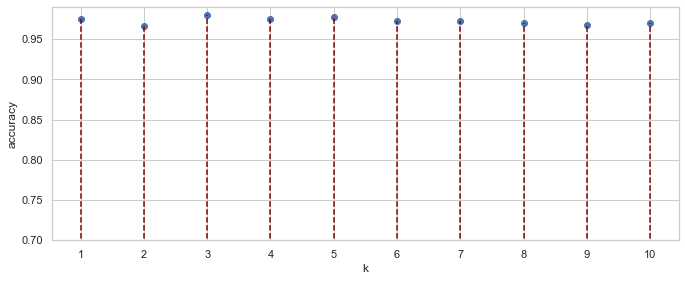

In [ ]:
k_range = range(1,11)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    scores.append(knn.score(X_test_scaled, y_test))

plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.vlines(k_range,0, scores, linestyle="dashed", colors='maroon')
plt.ylim(0.70,0.99)
plt.xticks([i for i in range(1,11)]);

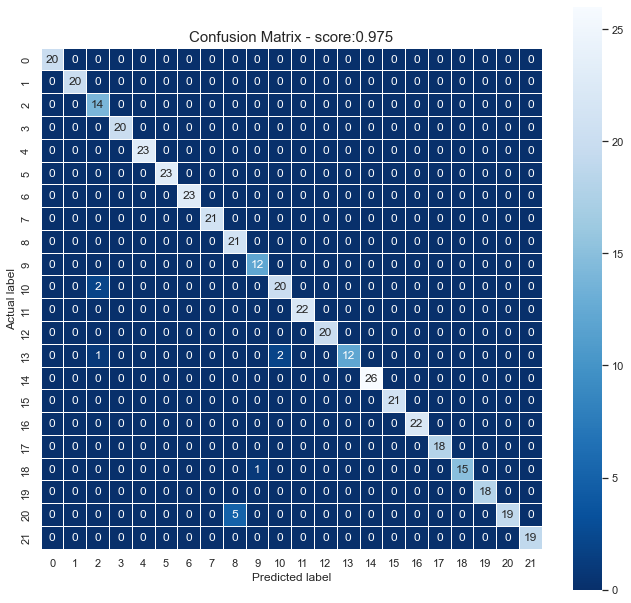

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.82      1.00      0.90        14
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        23
      coffee       1.00      1.00      1.00        23
      cotton       1.00      1.00      1.00        23
      grapes       1.00      1.00      1.00        21
        jute       0.81      1.00      0.89        21
 kidneybeans       0.92      1.00      0.96        12
      lentil       0.91      0.91      0.91        22
       maize       1.00      1.00      1.00        22
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      0.80      0.89        15
    mungbean       1.00      1.00      1.00        26
   muskmelon       1.00      1.00      1.00        21
      orange       1.00      1.00      1.00        22
      papaya       1.00    

In [ ]:
knn_model=KNeighborsClassifier(n_neighbors = 4)
knn_model.fit(X_train_scaled,y_train)
y_pred=knn_model.predict(X_test_scaled)
from sklearn import metrics

knn_cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(knn_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Confusion Matrix - score:'+str(metrics.accuracy_score(y_test,y_pred))
plt.title(all_sample_title, size = 15);
plt.show()
print(metrics.classification_report(y_test,y_pred))

**Xtreme Gradient Boosting Classifier**



In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_letrain = le.fit_transform(y_train)
y_letest = le.fit_transform(y_test)

In [ ]:
y_test

2040          jute
232       chickpea
2094          jute
59            rice
1293        grapes
           ...    
676       mungbean
1100         mango
1824       coconut
2197        coffee
494     pigeonpeas
Name: label, Length: 440, dtype: object

In [ ]:
XB = xgb.XGBClassifier()
XB.fit(X_train_scaled,y_letrain)
XB_pred = XB.score(X_test_scaled,y_letest)
XB_train_accuracy = XB.score(X_train_scaled,y_letrain)
pred_prob_XB = XB.predict_proba(X_test_scaled)

print("Training accuracy = ",XB.score(X_train_scaled,y_letrain))
#Print Test Accuracy
XB_accuracy = XB.score(X_test_scaled,y_letest)
print("Testing accuracy = ",XB.score(X_test_scaled,y_letest))

Training accuracy =  1.0
Testing accuracy =  0.990909090909091


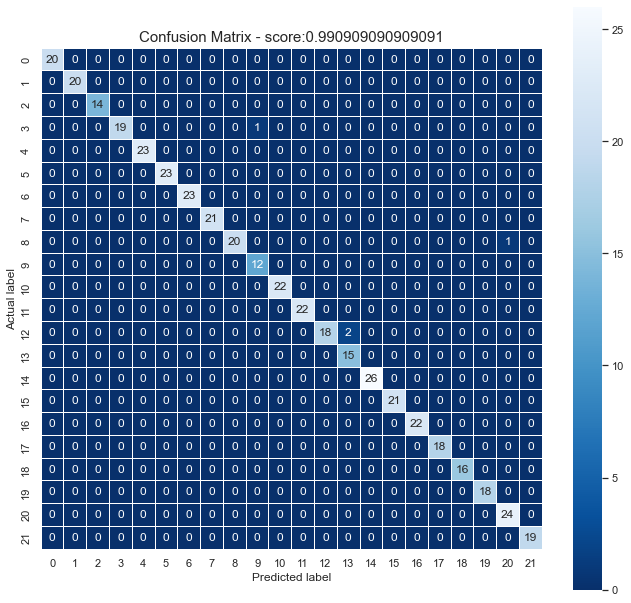

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20
           2       1.00      1.00      1.00        14
           3       1.00      0.95      0.97        20
           4       1.00      1.00      1.00        23
           5       1.00      1.00      1.00        23
           6       1.00      1.00      1.00        23
           7       1.00      1.00      1.00        21
           8       1.00      0.95      0.98        21
           9       0.92      1.00      0.96        12
          10       1.00      1.00      1.00        22
          11       1.00      1.00      1.00        22
          12       1.00      0.90      0.95        20
          13       0.88      1.00      0.94        15
          14       1.00      1.00      1.00        26
          15       1.00      1.00      1.00        21
          16       1.00      1.00      1.00        22
          17       1.00    

In [ ]:
XB_model=xgb.XGBClassifier()
XB_model.fit(X_train_scaled,y_letrain)
y_pred=XB_model.predict(X_test_scaled)
from sklearn import metrics

XB_cm = metrics.confusion_matrix(y_letest, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(XB_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Confusion Matrix - score:'+str(metrics.accuracy_score(y_letest,y_pred))
plt.title(all_sample_title, size = 15);
plt.show()
print(metrics.classification_report(y_letest,y_pred))

# **Model Comparison**

**Comparison Table of All Models**

In [ ]:
predictions_acc = { "Model": ['Decision Tree', 'Random Forest', 'SVC','KNeighbors','XGB'],
"Accuracy": [tree_pred, rf_pred, svm_pred,knn_pred,XB_pred]}

In [ ]:
model_acc = pd.DataFrame(predictions_acc, columns=["Model", "Accuracy"])

In [ ]:
model_acc

,Model,Accuracy
0,Decision Tree,0.981818
1,Random Forest,0.986364
2,SVC,0.775000
3,KNeighbors,0.977273
4,XGB,0.990909


In [ ]:
print("Average accuracy : {:.3f}".format(model_acc.Accuracy.mean()))

Average accuracy : 0.942


In [ ]:
Model_Name = ['Decision Tree', 'Random Forest',  'SVC','KNeighbors','XGB']
Accuracy = [tree_pred, rf_pred,  svm_pred,knn_pred,XB_pred]

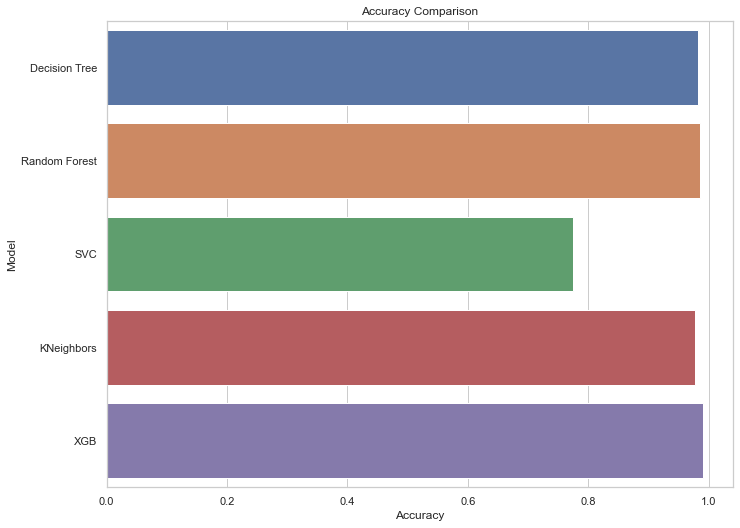

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Accuracy Comparison')
plt.xlabel('Accuracy')
plt.ylabel('Model')
sns.barplot(x = Accuracy,y = Model_Name)
plt.show()


**Comparison of Training and Testing Accuracy of all the Models**

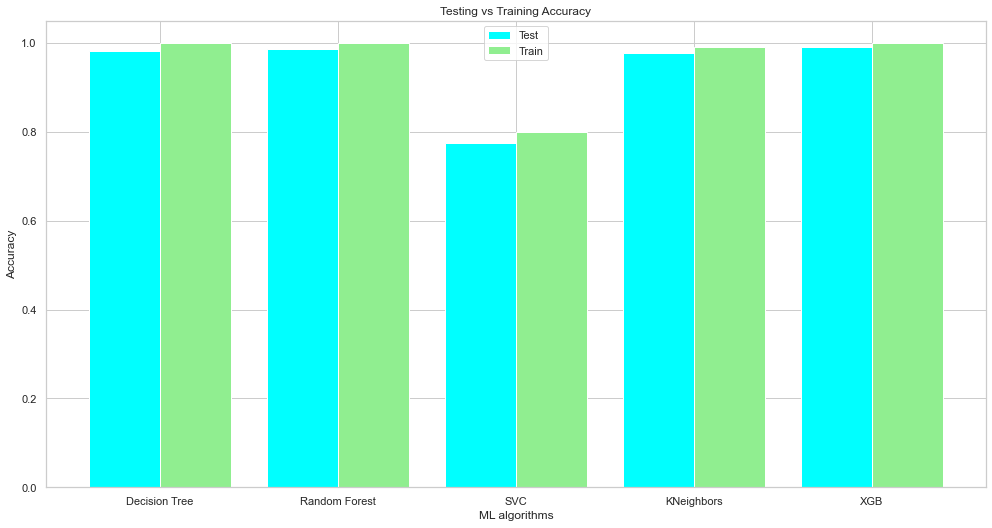

In [ ]:
label = ['Decision Tree', 'Random Forest', 'SVC','KNeighbors','XGB']
Test = [tree_accuracy, rf_accuracy, svm_accuracy,knn_accuracy,XB_accuracy]
Train = [tree_train_accuracy, rf_train_accuracy, svm_train_accuracy,knn_train_accuracy,XB_train_accuracy]

f, ax = plt.subplots(figsize=(15,8)) # set the size that you'd like (width, height)
X_axis = np.arange(len(label))
plt.bar(X_axis - 0.2,Test, 0.4, label = 'Test', color=('cyan'))
plt.bar(X_axis + 0.2,Train, 0.4, label = 'Train', color=('lightgreen'))

plt.xticks(X_axis, label)
plt.xlabel("ML algorithms")
plt.ylabel("Accuracy")
plt.title("Testing vs Training Accuracy")
plt.legend()
#plt.savefig('train vs test.png')
plt.show()

In [ ]:
#Conclusion
#Columnwise outlier removal leaves dataset imbalanced
#The training and testing accuracy are nearly equal
#LSupport Vector Classifier is providing comparatively least accuracy that is 76%.

# **Real Time Prediction of Crops**

In [ ]:
y_train_pred = XB_model.predict(X_train_scaled)
print("Accuracy Score of Random Forest:",accuracy_score(y_train,y_train_pred))

Accuracy Score of Random Forest: 0.0


In [ ]:
y_lepred = le.inverse_transform(y_pred)

In [ ]:
output = pd.DataFrame({'Real_class': y_test, 'Predicted_class': y_lepred})
output

,Real_class,Predicted_class
2040,jute,jute
232,chickpea,chickpea
2094,jute,jute
59,rice,rice
1293,grapes,grapes
...,...,...
676,mungbean,mungbean
1100,mango,mango
1824,coconut,coconut
2197,coffee,coffee


In [ ]:
prediction= rf_model.predict(np.array([[20,13,9,63.09348056,60.11593810000001,6.033550195,65.49730729]]))
print("The Suggested Crop for Given Climatic Condition is :", prediction)

The Suggested Crop for Given Climatic Condition is : ['apple']
